In [1]:
!git clone https://github.com/utsav-desai/CS772.git
!pip install accelerate -U datasets
!pip install transformers[torch]S

fatal: destination path 'CS772' already exists and is not an empty directory.
ERROR: Invalid requirement: 'transformers[torch]S'


In [2]:
!nvidia-smi

Sun May  5 09:27:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Libraries

In [3]:
import os
os.environ["WANDB_DISABLED"] = "True"
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric

In [4]:
!pip install spacy_cleaner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi-cli 0.0.2 requires typer>=0.12.3, but you have typer 0.9.4 which is incompatible.
gradio 4.29.0 requires typer<1.0,>=0.12; sys_platform != "emscripten", but you have typer 0.9.4 which is incompatible.


In [5]:
import spacy, re
import spacy_cleaner
from spacy_cleaner.processing import removers, mutators

In [6]:
%%time
train = pd.read_csv("./CS772/Project/data/train.csv")
test = pd.read_csv("./CS772/Project/data/test.csv")

CPU times: user 35 ms, sys: 12 ms, total: 47 ms
Wall time: 49.7 ms


In [7]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
len(train)

7613

In [9]:
max(train["id"])

10873

In [10]:
train["keyword"].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [11]:
train["location"].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [12]:
train = train[train.columns[3:]]  # Removed Other columns
test = test[test.columns[3:]]

In [13]:
train["text"] = train["text"].str.lower()
test["text"] = test["text"].str.lower()

In [14]:
test.head(5)

,text
0,just happened a terrible car crash
1,"heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,apocalypse lighting. #spokane #wildfires
4,typhoon soudelor kills 28 in china and taiwan


In [15]:
train.head(5)

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


In [16]:
# Setting up the pipeline to clean the data using spacy
nlp = spacy.load("en_core_web_sm")
nlp

In [17]:
pipeline = spacy_cleaner.Cleaner(
    nlp,  # pre-built language model
    removers.remove_email_token,
    removers.remove_punctuation_token,
    removers.remove_stopword_token,
    removers.remove_url_token,
    removers.remove_number_token,
    mutators.mutate_lemma_token,
)

In [18]:
train.head(5)

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


In [19]:
%%time
train["text"] = pipeline.clean(train["text"])

Cleaning Progress: 100%|██████████| 7613/7613 [00:35<00:00, 217.21it/s]

CPU times: user 25.7 s, sys: 234 ms, total: 25.9 s
Wall time: 35.1 s


In [20]:
train.head(5)  # Now we got the clean texts

,text,target
0,deed reason earthquake allah forgive,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive wildfire evacuation order calif...,1
4,get send photo ruby alaska smoke wildfire pour...,1


In [21]:
train["text"][100]

'.@norwaymfa bahrain police previously die road accident kill explosion'

In [22]:
train["text"][102]

'@aftershock_delo scuf ps live game cya'

## there were tags(usually a name , which doesnot have any effect in the output) in the sentences and some unwanted symbols which accompanies

eg .ir icemoon aftershock dubstep trapmusic dnb edm dance ices\x89 (I have seen this,but forget the which line it is ,😂)

In [23]:
# let us remove the tags and unwanted symbols to make it more clean

SymbolRemover = lambda x: re.sub("[#=><\/.]", "", x)

TagRemover = lambda word: re.sub("@\w+", "", word)

train["text"] = train["text"].apply(SymbolRemover)

train["text"] = train["text"].apply(TagRemover)

In [24]:
train["text"][102]

' scuf ps live game cya'

In [25]:
train["text"][100]

' bahrain police previously die road accident kill explosion'

In [26]:
!ls

CS772  distilbert  flagged  my_model_weights  sample_data


<div style="background-image: url('https://media.istockphoto.com/id/1341408852/video/colored-smoke-on-a-dark-background-blue-and-red-light-with-smoke.jpg?s=640x640&k=20&c=v2DQUY8IVbli_6FH_9KAs6YWRXlDdYiBJHfp7JFh7NY='); background-size: cover; background-position: center; border-radius: 10px; padding: 20px; color: #ffffff;">
    <h3>Using the pre-build model from Hugging face(Transformers) for Classification</h3>
</div>

In [27]:
# Let's write the logic for the Model in pytorch
from transformers import (
    AutoTokenizer,
    DataCollator,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)


<div style="background-image: url('https://media.istockphoto.com/id/1341408852/video/colored-smoke-on-a-dark-background-blue-and-red-light-with-smoke.jpg?s=640x640&k=20&c=v2DQUY8IVbli_6FH_9KAs6YWRXlDdYiBJHfp7JFh7NY='); background-size: cover; background-position: center; border-radius: 10px; padding: 20px; color: #ffffff;">
    <h2>Using the "distilbert/distilbert-base-uncased" from transformers</h2>
    <a href=https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#>Click to Refer for further<a>
</div>

In [28]:
model = "distilbert/distilbert-base-uncased"
learning_rate = 2e-5
epochs = 16

In [29]:
train_split, valid_split = train_test_split(
    train, test_size=0.2
)  # sppliting the data for train and valid

In [30]:
tokenizer = AutoTokenizer.from_pretrained(
    model
)  # Maping the TOkenizer for the model classification
train_ds = Dataset.from_pandas(train_split)
valid_ds = Dataset.from_pandas(valid_split)
test_ds = Dataset.from_pandas(test)


def process_token(example, tokenizer=tokenizer):
    return tokenizer(example["text"])


tokenized_train = train_ds.map(process_token)
tokenized_valid = valid_ds.map(process_token)
tokenized_test = test_ds.map(process_token)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [31]:
tokenized_train[0]

{'text': 'common running injury avoid',
 'target': 0,
 '__index_level_0__': 4593,
 'input_ids': [101, 2691, 2770, 4544, 4468, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [32]:
tokenized_test[0]

{'text': 'just happened a terrible car crash',
 'input_ids': [101, 2074, 3047, 1037, 6659, 2482, 5823, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
columns_to_remove = ["__index_level_0__"]
train_dataset = tokenized_train.remove_columns(columns_to_remove)
valid_dataset = tokenized_valid.remove_columns(columns_to_remove)
test_dataset = tokenized_test

In [34]:
train_dataset[0]

{'text': 'common running injury avoid',
 'target': 0,
 'input_ids': [101, 2691, 2770, 4544, 4468, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [35]:
valid_dataset[1]

{'text': 'new summer long thin body bag hip word skirt blue m',
 'target': 0,
 'input_ids': [101,
  2047,
  2621,
  2146,
  4857,
  2303,
  4524,
  5099,
  2773,
  9764,
  2630,
  1049,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [36]:
train_dataset = train_dataset.rename_column("target", "label")
valid_dataset = valid_dataset.rename_column("target", "label")

In [37]:
train_dataset[0]

{'text': 'common running injury avoid',
 'label': 0,
 'input_ids': [101, 2691, 2770, 4544, 4468, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [38]:
test_dataset[0]

{'text': 'just happened a terrible car crash',
 'input_ids': [101, 2074, 3047, 1037, 6659, 2482, 5823, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [39]:
def compute_metrics(eval_pred):
    load_acc = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = load_acc.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    print(f"Accuracy: {acc} \nF1: {f1}")
    return {"acc": acc, "f1": f1}

In [40]:
# train_dataset

<h2>Training the DistiltBert model</h2>

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(model)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    learning_rate=learning_rate,
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    output_dir="distilbert",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [42]:
# trainer.args

In [43]:
trainer.train()

Step,Training Loss
500,0.440000
1000,0.321800
1500,0.232300
2000,0.144900
2500,0.113800
3000,0.082300
3500,0.062300
4000,0.059000
4500,0.051000
5000,0.042100


TrainOutput(global_step=6096, training_loss=0.13367325407782876, metrics={'train_runtime': 397.8111, 'train_samples_per_second': 244.94, 'train_steps_per_second': 15.324, 'total_flos': 592011293215392.0, 'train_loss': 0.13367325407782876, 'epoch': 16.0})

In [54]:
trainer.state.log_history

[{'loss': 0.44,
  'grad_norm': 4.655557155609131,
  'learning_rate': 1.835958005249344e-05,
  'epoch': 1.3123359580052494,
  'step': 500},
 {'loss': 0.3218,
  'grad_norm': 13.00670051574707,
  'learning_rate': 1.671916010498688e-05,
  'epoch': 2.6246719160104988,
  'step': 1000},
 {'loss': 0.2323,
  'grad_norm': 2.329192876815796,
  'learning_rate': 1.5078740157480316e-05,
  'epoch': 3.937007874015748,
  'step': 1500},
 {'loss': 0.1449,
  'grad_norm': 3.7008907794952393,
  'learning_rate': 1.3438320209973755e-05,
  'epoch': 5.2493438320209975,
  'step': 2000},
 {'loss': 0.1138,
  'grad_norm': 8.784838676452637,
  'learning_rate': 1.1797900262467192e-05,
  'epoch': 6.561679790026247,
  'step': 2500},
 {'loss': 0.0823,
  'grad_norm': 0.9720982313156128,
  'learning_rate': 1.015748031496063e-05,
  'epoch': 7.874015748031496,
  'step': 3000},
 {'loss': 0.0623,
  'grad_norm': 2.4014062881469727,
  'learning_rate': 8.517060367454069e-06,
  'epoch': 9.186351706036746,
  'step': 3500},
 {'loss

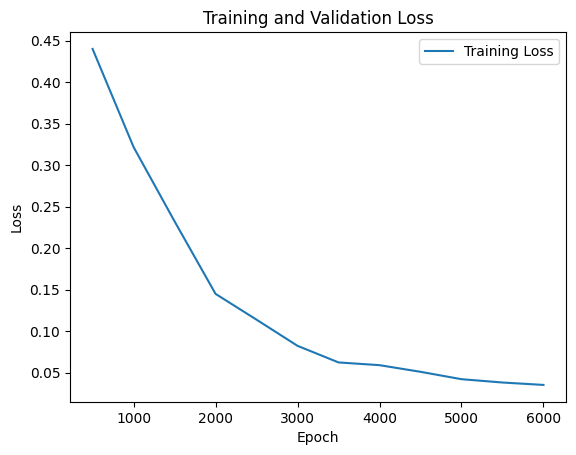

In [59]:
import matplotlib.pyplot as plt
# Plot training and validation loss
train_loss = [x["loss"] for x in trainer.state.log_history[:-1]]
steps = [x["step"] for x in trainer.state.log_history[:-1]]

plt.plot(steps,train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<div style="background-image: url('https://media.istockphoto.com/id/1341408852/video/colored-smoke-on-a-dark-background-blue-and-red-light-with-smoke.jpg?s=640x640&k=20&c=v2DQUY8IVbli_6FH_9KAs6YWRXlDdYiBJHfp7JFh7NY='); background-size: cover; background-position: center; border-radius: 10px; padding: 20px; color: #ffffff;">
    <h2>Getting the Predictions</h2>
</div>

In [44]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6090
})

In [45]:
test_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 3263
})

In [46]:
predictions = trainer.predict(test_dataset=train_dataset, ignore_keys=["label"])

<ipython-input-39-a673c1bbe437>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_acc = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: 0.986863711001642 
F1: 0.9847735059002665


In [47]:
predictions.predictions[0]

array([ 4.3180733, -4.596767 ], dtype=float32)

In [48]:
predictions_Strength_Class = np.argmax(
    predictions.predictions, axis=1
)  # Return the indexof the max value classtrain_dataset

In [49]:
predictions_Strength_Class  # Shows the label of our texts/tweets

array([0, 1, 0, ..., 1, 0, 0])

<div style="background-image: url('https://media.istockphoto.com/id/1341408852/video/colored-smoke-on-a-dark-background-blue-and-red-light-with-smoke.jpg?s=640x640&k=20&c=v2DQUY8IVbli_6FH_9KAs6YWRXlDdYiBJHfp7JFh7NY='); background-size: cover; background-position: center; border-radius: 10px; padding: 20px; color: #ffffff;">
    <h2>Making the Submission File</h2>
</div>

In [50]:
!du -h ./my_model_weights/

256M	./my_model_weights/


In [60]:
model.save_pretrained("my_model_weights")

In [61]:


# Importing the model weights in a new model instance
new_model = AutoModelForSequenceClassification.from_pretrained(
    "my_model_weights"
)


In [62]:
!pip install gradio

  Using cached typer-0.12.3-py3-none-any.whl (47 kB)
  Attempting uninstall: typer
    Found existing installation: typer 0.9.4
    Uninstalling typer-0.9.4:
      Successfully uninstalled typer-0.9.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


In [54]:
# prompt: using the weights saved in the above cell, make a gradio UI for testing this model. The input should be a text sentence and output is the model output.

import gradio as gr

def classify_text(text):
    # Preprocess the text
    text = text.lower()
    text = re.sub("[#=><\/.]", "", text)
    text = re.sub("@\w+", "", text)

    # Tokenize the text
    tokenized_text = tokenizer(text)

    # Convert the tokenized text to a tensor
    input_ids = torch.tensor(tokenized_text["input_ids"]).unsqueeze(0)
    attention_mask = torch.tensor(tokenized_text["attention_mask"]).unsqueeze(0)

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained("my_model_weights")

    # Make predictions
    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Return the predictions
    return predictions.item()

demo = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(label="Enter a text sentence here"),
    outputs="label",
    examples=[
        "This is a disaster!",
        "Earthquake is expected in china !",
        "I'm feeling happy.",
    ],
)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1d70afc8e6414ee0c7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
submission["target"] = predictions_Strength_Class
submission = submission.set_index("id", drop=True)
submission.to_csv("/kaggle/working/submission.csv")

In [ ]:
submission.head(5)

In [ ]:
predictions = trainer.predict(test_dataset=test_dataset)